## Import libraries

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from tokenizers import Tokenizer, models, pre_tokenizers, trainers
from tokenizers.normalizers import NFKC
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt

In order to generate the data I follow the approach in Deep Learning for Symbolic Mathematics (https://doi.org/10.48550/arXiv.1912.01412). <br>
I modified the code by adding gen_taylor_approx(self, rng) procedure inside /src/envs/char_sp.py. The output expression are in the prefix notation. <br>
Additionally, there is a also a Mathematica code that generates random function in the rest of the GitHub repo. <br> <br>

In the following part of the notebook we write up standard encode-decoder acrchitecture for LSTM and Transformer approach and examin test loss as well as performance on one example on the test set.


## LSTM approach

In [82]:
class Seq2SeqLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim=512, hidden_dim=128, num_layers=2, dropout=0.3):
        super(Seq2SeqLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_token_id)
        self.encoder_lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.decoder_lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.linear = nn.Linear(hidden_dim, vocab_size)

    def forward(self, src, tgt):
        src, tgt = self.embedding(src), self.embedding(tgt)
        _, (hidden, mem_cell) = self.encoder_lstm(src)
        output, _ = self.decoder_lstm(tgt, (hidden, mem_cell))
        return self.linear(output)
    
def encode_sequence(text, tokenizer):
    return torch.tensor(tokenizer.encode(text).ids, dtype=torch.long)

def pad_sequences(sequences, pad_token_id):
    return pad_sequence(sequences, batch_first=True, padding_value=pad_token_id)

def train_lstm(model, train_loader, val_loader, epochs, criterion, optimizer, device, model_path="best_lstm_model.pth", patience=20):
    best_val_loss = float('inf')
    epochs_since_improvement = 0  

    train_losses = []  # training loss
    val_losses = []    # validation loss

    for epoch in range(epochs):
        if epochs_since_improvement >= patience:
            print("..early stopping triggered.") # too much time with no imporvement
            break
        
        model.train()
        total_train_loss = 0
        for src, tgt in train_loader:
            src, tgt = src.to(device), tgt.to(device)
            tgt_input, tgt_output = tgt[:, :-1], tgt[:, 1:]
            optimizer.zero_grad()
            outputs = model(src, tgt_input)
            loss = criterion(outputs.view(-1, vocab_size), tgt_output.contiguous().view(-1))
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss) 
        
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for src, tgt in val_loader:
                src, tgt = src.to(device), tgt.to(device)
                tgt_input, tgt_output = tgt[:, :-1], tgt[:, 1:]
                outputs = model(src, tgt_input)
                loss = criterion(outputs.view(-1, vocab_size), tgt_output.contiguous().view(-1))
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss) 

        print(f"..epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_path)
            print(f"..best model saved with val loss = {best_val_loss}!")
            epochs_since_improvement = 0  
        else:
            epochs_since_improvement += 1  

    return model_path, train_losses, val_losses

def evaluate_lstm(model, test_loader, device, criterion, vocab_size):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for src, tgt in test_loader:
            src, tgt = src.to(device), tgt.to(device)
            tgt_input, tgt_output = tgt[:, :-1], tgt[:, 1:]
            outputs = model(src, tgt_input)
            loss = criterion(outputs.view(-1, vocab_size), tgt_output.contiguous().view(-1))
            total_loss += loss.item()
    print(f"Test Loss: {total_loss / len(test_loader):.4f}")

def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Training Loss", marker='o')
    plt.plot(val_losses, label="Validation Loss", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train and val loss over epochs")
    plt.grid(True)
    plt.legend()
    plt.show()


In [102]:
# we first load in the expressions in prefix form and train the tokenizer which we then use to encode the prefix expresseion into a sequence of ints
file_path = "/Users/adepope/Documents/symbolic_py/data.prefix.expressions"
df = pd.read_csv(file_path, sep='\t', header=None, names=['f', 'taylor_f'], engine='python', nrows=10000)

tokenizer = Tokenizer(models.BPE())
tokenizer.normalizer = NFKC()
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
trainer = trainers.BpeTrainer(special_tokens=["<PAD>", "<SOS>", "<EOS>", "<UNK>"])
tokenizer.train_from_iterator(df["f"].tolist() + df["taylor_f"].tolist(), trainer)

df["f_tokens"] = df["f"].apply(lambda x: encode_sequence(x, tokenizer))
df["taylor_f_tokens"] = df["taylor_f"].apply(lambda x: encode_sequence(x, tokenizer))

pad_token_id = tokenizer.token_to_id("<PAD>")
padded_f_tokens = pad_sequences(df["f_tokens"].tolist(), pad_token_id)
padded_taylor_f_tokens = pad_sequences(df["taylor_f_tokens"].tolist(), pad_token_id)

# train / validation / test split of the 10k samples we loaded
train_f, test_f, train_taylor_f, test_taylor_f = train_test_split(padded_f_tokens, padded_taylor_f_tokens, test_size=0.2, random_state=42)
train_f, val_f, train_taylor_f, val_taylor_f = train_test_split(train_f, train_taylor_f, test_size=0.1, random_state=42)

train_dataset, val_dataset, test_dataset = TensorDataset(train_f, train_taylor_f), TensorDataset(val_f, val_taylor_f), TensorDataset(test_f, test_taylor_f)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

vocab_size = tokenizer.get_vocab_size()
print(f"..vocabulary size is {vocab_size}")




..vocabulary size is 70


In [84]:
# training and evaluation

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # working locally on mac, change to 'gpu' if working on a HPC
model = Seq2SeqLSTM(vocab_size).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=pad_token_id)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
num_epochs = 256
best_model_path, train_losses, val_losses = train_lstm(model, train_loader, val_loader, num_epochs, criterion, optimizer, device)

model.load_state_dict(torch.load(best_model_path))
evaluate_lstm(model, test_loader, device, criterion, vocab_size)


..epoch [1/256], Train Loss: 2.6141, Val Loss: 1.8136
..best model saved with val loss = 1.8135580253601074!
..epoch [2/256], Train Loss: 1.6440, Val Loss: 1.4858
..best model saved with val loss = 1.485820460319519!
..epoch [3/256], Train Loss: 1.4254, Val Loss: 1.3332
..best model saved with val loss = 1.333234691619873!
..epoch [4/256], Train Loss: 1.2988, Val Loss: 1.2308
..best model saved with val loss = 1.2308308172225952!
..epoch [5/256], Train Loss: 1.2132, Val Loss: 1.1599
..best model saved with val loss = 1.1598756122589111!
..epoch [6/256], Train Loss: 1.1496, Val Loss: 1.1065
..best model saved with val loss = 1.1065454626083373!
..epoch [7/256], Train Loss: 1.1001, Val Loss: 1.0599
..best model saved with val loss = 1.0599498224258423!
..epoch [8/256], Train Loss: 1.0560, Val Loss: 1.0250
..best model saved with val loss = 1.0249543380737305!
..epoch [9/256], Train Loss: 1.0216, Val Loss: 0.9937
..best model saved with val loss = 0.9936593556404114!
..epoch [10/256], Tra

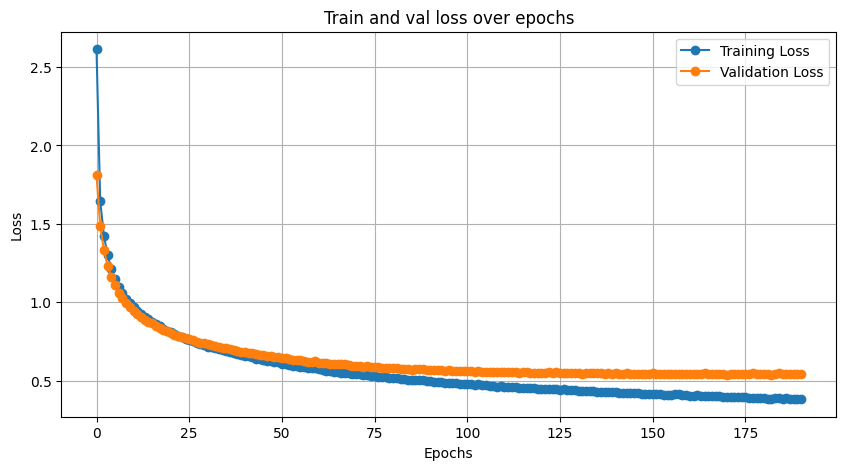

In [85]:
plot_loss(train_losses, val_losses)

In [134]:
best_model_path = "best_lstm_model.pth"
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # working locally on mac, change to 'gpu' if working on a HPC
model = Seq2SeqLSTM(vocab_size).to(device)
model.load_state_dict(torch.load(best_model_path))
model.eval()

example_idx = 4
input_function = test_f[example_idx]
input_target = test_taylor_f[example_idx]
target_value = tokenizer.decode(input_target.cpu().numpy())
function_value = tokenizer.decode(input_function.cpu().numpy())

encoded_function = input_function.unsqueeze(0).to(device)
encoded_target = input_target.unsqueeze(0).to(device)
tgt_input = encoded_target[:, :-1]
tgt_output = encoded_target[:, 1:]

with torch.no_grad():
    outputs = model(encoded_function, tgt_input)
    
predicted_ids = outputs.argmax(dim=-1)[0].cpu().numpy()
predicted_output = tokenizer.decode(predicted_ids)

print(f"Input Function: {function_value}")
print(f"Predicted Expression: {tokenizer.decode(encoded_target[:,0].cpu().numpy())}" + " " +  predicted_output[:len(target_value)])
print(f"Target Expression: {target_value}")


Input Function: add x mul INT - 1 mul x add INT + 5 x
Predicted Expression: add x INT + 2 x x INT + 2 mul div + 1 pow mul m
Target Expression: add mul INT - 1 pow x INT + 2 mul INT - 4 x


# Transformer approach

In [95]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=256, nhead=4, num_layers=2, dim_feedforward=1024, max_seq_len=512, dropout=0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = nn.Parameter(torch.randn(1, max_seq_len, d_model))

        self.transformer = nn.Transformer(
            d_model=d_model, 
            nhead=nhead, 
            num_encoder_layers=num_layers, 
            num_decoder_layers=num_layers, 
            dim_feedforward=dim_feedforward,
            batch_first=True,
            dropout=dropout
        )

        self.output_layer = nn.Linear(d_model, vocab_size)

    def forward(self, src, tgt):
        src_emb = self.embedding(src) + self.positional_encoding[:, :src.size(1), :]
        tgt_emb = self.embedding(tgt) + self.positional_encoding[:, :tgt.size(1), :]

        output = self.transformer(src_emb, tgt_emb)
        return self.output_layer(output)
    
def encode_sequence(sequence, tokenizer, max_len=512):
    tokens = tokenizer.encode(sequence).ids
    tokens = tokens[:max_len] + [0] * (max_len - len(tokens))
    return torch.tensor(tokens, dtype=torch.long)

def train_transformer(model, train_loader, val_loader, epochs, criterion, optimizer, device, save_path, clip_grad=1.0):
    best_val_loss = float("inf")
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for src, tgt in train_loader:
            src, tgt = src.to(device), tgt.to(device)
            optimizer.zero_grad()
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]
            outputs = model(src, tgt_input)
            loss = criterion(outputs.view(-1, outputs.size(-1)), tgt_output.contiguous().view(-1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = evaluate_transformer(model, val_loader, criterion, device)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), save_path)
            print(f"Best model saved at epoch {epoch+1} with validation loss {best_val_loss:.4f}")

def evaluate_transformer(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for src, tgt in data_loader:
            src, tgt = src.to(device), tgt.to(device)
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]
            outputs = model(src, tgt_input)
            loss = criterion(outputs.view(-1, outputs.size(-1)), tgt_output.contiguous().view(-1))
            total_loss += loss.item()
    return total_loss / len(data_loader)


In [97]:

file_path = "/Users/adepope/Documents/symbolic_py/data.prefix.expressions"
df = pd.read_csv(file_path, sep='\t', header=None, names=['f', 'taylor_f'], engine='python', nrows=10000)

tokenizer = Tokenizer(models.BPE())
tokenizer.normalizer = NFKC()
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
trainer = trainers.BpeTrainer(special_tokens=["<PAD>", "<SOS>", "<EOS>", "<UNK>"])
tokenizer.train_from_iterator(df["f"].tolist() + df["taylor_f"].tolist(), trainer)

df["f_tokens"] = df["f"].apply(lambda x: encode_sequence(x, tokenizer))
df["taylor_f_tokens"] = df["taylor_f"].apply(lambda x: encode_sequence(x, tokenizer))
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

train_dataset = TensorDataset(
    torch.stack(list(train_df["f_tokens"])), 
    torch.stack(list(train_df["taylor_f_tokens"]))
)
val_dataset = TensorDataset(
    torch.stack(list(val_df["f_tokens"])), 
    torch.stack(list(val_df["taylor_f_tokens"]))
)
test_dataset = TensorDataset(
    torch.stack(list(test_df["f_tokens"])), 
    torch.stack(list(test_df["taylor_f_tokens"]))
)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = Seq2SeqTransformer(vocab_size=tokenizer.get_vocab_size()).to(device)

epochs = 20
learning_rate = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

best_model_path = "best_transformer_model_taylor4.pth"

train_transformer(model, train_loader, val_loader, epochs, criterion, optimizer, device, best_model_path)

model.load_state_dict(torch.load(best_model_path))
test_loss = evaluate_transformer(model, test_loader, criterion, device)
print(f"Final Test Loss: {test_loss:.4f}")





Epoch 1/20 - Train Loss: 0.2650 - Val Loss: 0.1679
Best model saved at epoch 1 with validation loss 0.1679
Epoch 2/20 - Train Loss: 0.1515 - Val Loss: 0.1445
Best model saved at epoch 2 with validation loss 0.1445
Epoch 3/20 - Train Loss: 0.1288 - Val Loss: 0.1184
Best model saved at epoch 3 with validation loss 0.1184
Epoch 4/20 - Train Loss: 0.1030 - Val Loss: 0.0955
Best model saved at epoch 4 with validation loss 0.0955
Epoch 5/20 - Train Loss: 0.0851 - Val Loss: 0.0797
Best model saved at epoch 5 with validation loss 0.0797
Epoch 6/20 - Train Loss: 0.0713 - Val Loss: 0.0672
Best model saved at epoch 6 with validation loss 0.0672
Epoch 7/20 - Train Loss: 0.0600 - Val Loss: 0.0567
Best model saved at epoch 7 with validation loss 0.0567
Epoch 8/20 - Train Loss: 0.0505 - Val Loss: 0.0454
Best model saved at epoch 8 with validation loss 0.0454
Epoch 9/20 - Train Loss: 0.0418 - Val Loss: 0.0374
Best model saved at epoch 9 with validation loss 0.0374
Epoch 10/20 - Train Loss: 0.0354 -

In [126]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = Seq2SeqTransformer(vocab_size=tokenizer.get_vocab_size()).to(device)
best_model_path = "best_transformer_model_taylor4.pth"
model.load_state_dict(torch.load(best_model_path))
model.eval()

example_idx = 1
input_function = test_df.iloc[example_idx]["f"]
target_value = test_df.iloc[example_idx]["taylor_f"]

encoded_input = encode_sequence(input_function, tokenizer)
encoded_input = encoded_input.unsqueeze(0).to(device)
encoded_target = encode_sequence(target_value, tokenizer).unsqueeze(0).to(device)

tgt_input = encoded_target[:, :-1]
tgt_output = encoded_target[:, 1:]

with torch.no_grad():
    outputs = model(encoded_input, tgt_input)

# print(outputs)
predicted_ids = outputs.argmax(dim=-1)[0].cpu().numpy()
# print(predicted_ids)
predicted_output = tokenizer.decode(predicted_ids)

print(f"Input Function: {input_function}")
# print(tokenizer.decode(encoded_target[:,0]))
print(f"Predicted Expression: {tokenizer.decode(encoded_target[:,0].cpu().numpy())}" + " " +  predicted_output)
print(f"Target Expression: {target_value}")

Input Function: add x add pow x INT+ 2 mul x exp x
Predicted Expression: add mul div INT + 1 INT + 2 pow x INT + 3 add mul INT + 2 x add mul INT + 2 pow x INT + 2 mul div INT + 1 INT + 6 pow x INT + 4
Target Expression: add mul div INT+ 1 INT+ 2 pow x INT+ 3 add mul INT+ 2 x add mul INT+ 2 pow x INT+ 2 mul div INT+ 1 INT+ 6 pow x INT+ 4
